#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor
plt.rcParams["figure.figsize"] = (16,4)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('taxi.csv',index_col=[0],parse_dates=[0])

Мы будем решать задачу машинного обучения с учителем. Целевой признак "num_orders".

In [3]:
df.isna().sum() # пропусков нет. преобразуем значения даты в индекс чтобы получить временные ряды

num_orders    0
dtype: int64

In [4]:
df.index.is_monotonic #индексы в хронологическом порядке

True

In [5]:
df = df.resample('1H').sum() #мы суммируем потому что для цели исследования важно количество заказов
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Предобработка закончена, приступим к анализу

## Анализ

Построим график

<Figure size 1152x576 with 0 Axes>

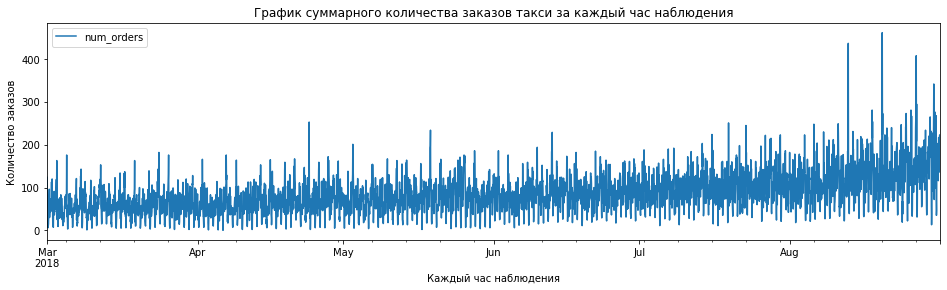

In [6]:
plt.figure(figsize=(16, 8))
df.plot(title='График суммарного количества заказов такси за каждый час наблюдения', xlabel='Каждый час наблюдения', ylabel='Количество заказов')
plt.show()

На графике мы видим распределние с марта по август 2018 года. В среднем количество заказов растет

Попробуем увидеть еще какие нибудь тенденции

In [7]:
decomposed = seasonal_decompose(df) 

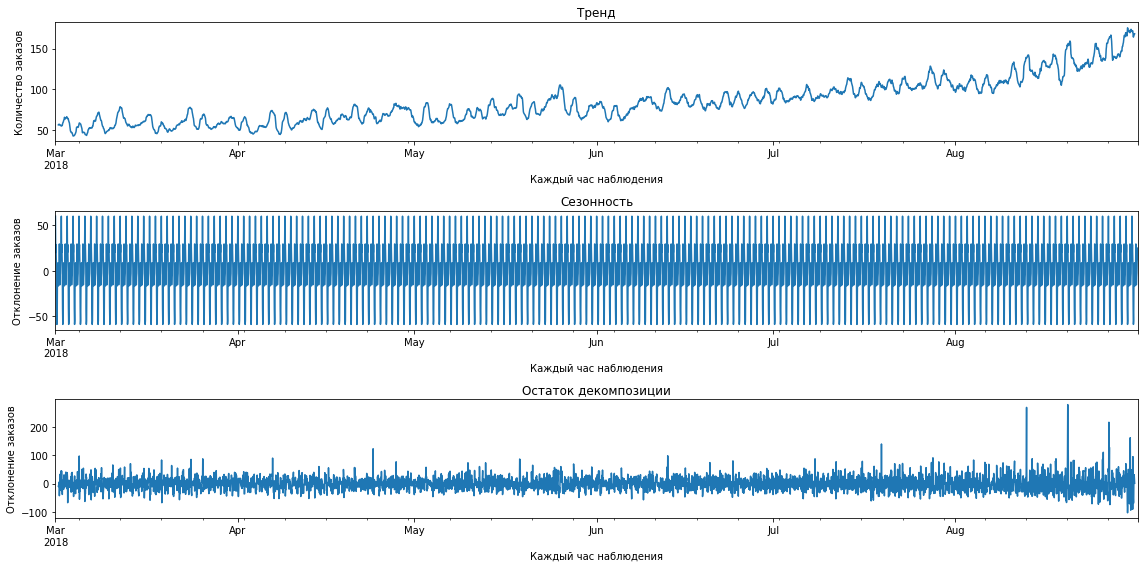

In [8]:
plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca(), xlabel='Каждый час наблюдения', ylabel='Количество заказов')
plt.title('Тренд')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca(), xlabel='Каждый час наблюдения', ylabel='Отклонение заказов')
plt.title('Сезонность')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca(), xlabel='Каждый час наблюдения', ylabel='Отклонение заказов')
plt.title('Остаток декомпозиции')
plt.tight_layout()

Мы видим отчетливо возрастающий тренд. Сезонность с периодом меньше месяца не является информативно для нас. Остатки не дают информации

<Figure size 1152x576 with 0 Axes>

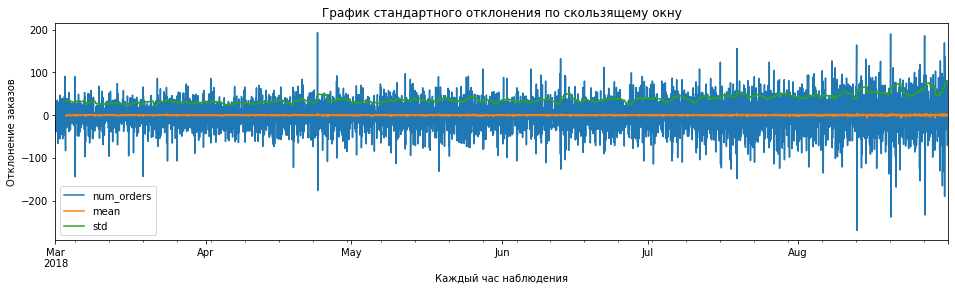

In [9]:
data = df.copy()
data = data - data.shift()
plt.figure(figsize=(16, 8))
data['mean'] = data['num_orders'].rolling(50,closed='left').mean()
data['std'] = data['num_orders'].rolling(50,closed='left').std()
data.plot(title='График стандартного отклонения по скользящему окну', xlabel='Каждый час наблюдения', ylabel='Отклонение заказов')
plt.show()

На графике видим скользящее среднее и скользящее стандартное отклонение. Ряд выглядит стационарным. Приступим к прогнозированию

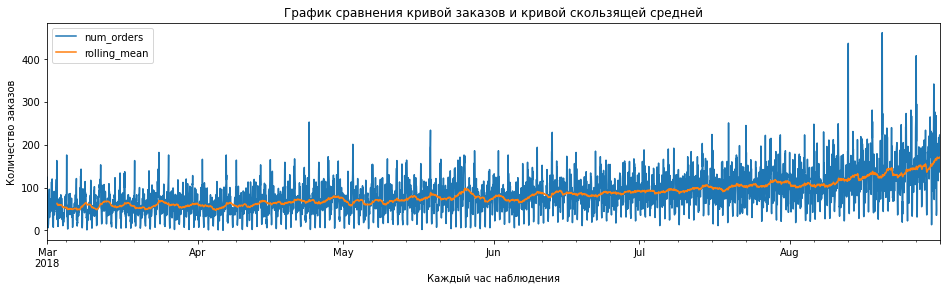

In [10]:
df['rolling_mean'] = df.shift().rolling(50).mean()
df.plot(xlabel='Каждый час наблюдения', ylabel='Количество заказов')
plt.title('График сравнения кривой заказов и кривой скользящей средней')
plt.show()

Скользящаяя средняя выглядит более стационарно чем график заказов, но она имеет так же растущий тренд поэтому по графику визуально сложно понять можно ли признать среднюю скользящую стационарной.

In [11]:
df = df.drop(['rolling_mean'],axis=1)

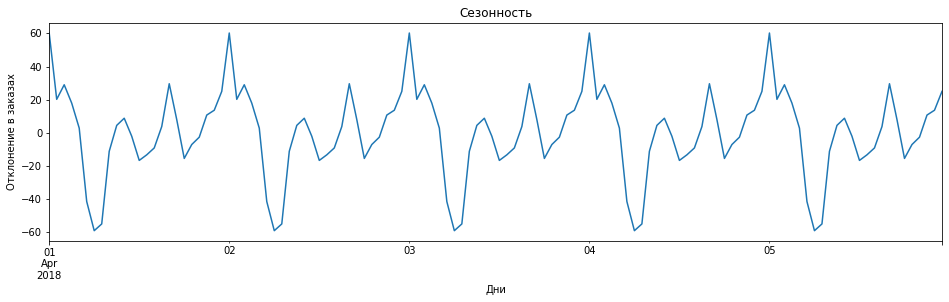

In [14]:
decomposed.seasonal['2018-04-01':'2018-04-05'].plot(ax=plt.gca(),xlabel='Дни',ylabel='Отклонение в заказах') # выберем произвольные 5 дней
plt.title('Сезонность')
plt.show()

На масштабе 5 дней мы видим циклично повторяющуюся закономерности во временном ряду. Мы видим пиковую нагрузку в 24 часа и минимальную в 6 утра. 4-8 часов утра наблюдается минимальное количество заказов, 22-24 часа максимальная наргузка с самым большим количеством заказов в интервале.

Данная сезонность носит часовой характер (повторения в определенные часы)

Пиковое время связано с загруженностью в аэропорте

С помощью теста Дики-Фуллера оценим наш временной ряд на стационарность. 
Нулевая гипотеза - временной ряд стационарен. Альтернативная гипотеза - ряд не стационарен.
Сначала оценим стационарность с уровнем значимости в 5%:

In [16]:
result = adfuller(df,autolag ='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["5%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд стационарен


Для уровня значимости в 5% нулевая гипотеза не отвергнута – Временной ряд стационарен.

Оценим стационарность с уровнем значимости в 1%:

In [17]:
result = adfuller(df,autolag ='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] > result[4]["1%"]:
    print ("Нулевая гипотеза отвергнута – Временной ряд не стационарен")
else:
    print ("Нулевая гипотеза не отвергнута – Временной ряд стационарен")

Критерий ADF: -3.068924
P-значение: 0.028940
Критические значения:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Нулевая гипотеза отвергнута – Временной ряд не стационарен


Для уровня значимости в 1% нулевая гипотеза отвергнута – временной ряд не стационарен.

### Промежуточный вывод:

Мы построили график для того чтобы визуально оценить распределние количества заказов такси.
В целом мы увидели тенденцию к увеличению заказов.

Для того чтобы увдиеть тренды и сезонности мы применили функцию декомпозиции. По графику трендов мы увмдели растущий тренд к увеличению числа заказов в среднем.

На масштабе 5 дней мы увидели циклично повторяющуюся закономерности во временном ряду. Мы видим пиковую нагрузку в 24 часа и минимальную в 6 утра. 4-8 часов утра наблюдается минимальное количество заказов, 22-24 часа максимальная наргузка с самым большим количеством заказов в интервале.

Затем мы построили график с рядом разниц. На графике увидели скользящее среднее и скользящее стандартное отклонение. Ряд выглядит стационарным визуально.

Для того чтобы более точно оценить в численном виде стационарность ряда мы провели теста Дики-Фуллера. Мы получили p-value равное 2,8% , таким образом в зависимости от заданной нами мере чувстительности alpha в 1% или 5% мы можем назвать ряд как стационарным так и не стационарным. 

Продолжим дальше работу, предполагая, что мера точности в пределах 5% нас устраивает и признаем ряд стационарным.

## Обучение

Выделим признаки. Год нам не нужен так как это одинаковый признак для всех. Построим функцию для вычисления построения остающих значений, календарных признаков, а так же скользящего среднего.

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    return

make_features(df, 20, 20)

In [19]:
df = df.dropna() #значения Nan будут мешать созданию моделей

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1) # создаем тестовую и тренировочную выборки не перемешивая, тест 10%

In [21]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'],axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'],axis=1)

### Обучим модель линейной регрессии

In [22]:
tss = TimeSeriesSplit(n_splits=3)

In [24]:
model_LinearReg = LinearRegression()

grid_space={}

grid = GridSearchCV(model_LinearReg, scoring='neg_root_mean_squared_error', param_grid=grid_space , cv=tss)

grid.fit(features_train, target_train)

print('Результат rmse: ', abs(grid.best_score_))

Результат rmse:  33.913844251206235


Среднеквадратическая ошибка для линейной модели на кросс-валидации показывает RMSE 33.9

### Обучим модель случайного леса

In [25]:
model_forestregressor = RandomForestRegressor(random_state=12345)

grid_space={'max_depth':[x for x in range(2,5,1)], 
'n_estimators':[x for x in range(10,31,5)]
}

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [26]:
grid = GridSearchCV(model_forestregressor, scoring=mse_scorer, param_grid=grid_space , cv=tss, n_jobs=-1)

grid.fit(features_train, target_train)

print('Лучшие гиперпараметры: ', grid.best_params_)
print('Лучший результат rmse: ', abs(grid.best_score_)**0.5)

Лучшие гиперпараметры:  {'max_depth': 4, 'n_estimators': 25}
Лучший результат rmse:  35.31107632287211


Среднеквадратическая ошибка для случайного леса на кросс-валидации показывает RMSE 35.3

### Обучим CatBoostRegressor 

In [27]:
model = CatBoostRegressor(verbose=0)

grid_space={'depth'         : [2,3,4,5],
            'iterations'    : [30, 50, 100]
}

grid = GridSearchCV(model, scoring='neg_root_mean_squared_error', param_grid=grid_space , cv=tss)

grid.fit(features_train, target_train)

print('Результат rmse: ', abs(grid.best_score_))

Результат rmse:  31.13673800474849


Среднеквадратическая ошибка для CatBoostRegressor на тренировочной выборке показывает RMSE 31.1

Промежуточный вывод. Из распределния времени мы выделили необходимые для создания модели признаки. Построили функцию для вычисления построения остающих значений, календарных признаков, а так же скользящего среднего.
Далее мы построили три модели для прогнозирования.

 - Линейнай регрессия показала RMSE 33.9
 - Случайный лес показал результат RMSE 35.3
 - CatBoostRegressor показал результат RMSE 31.1

По итогу лучший результат показал CatBoostRegressor. Проведем тестирование с ним. 

## Тестирование

In [28]:
model = CatBoostRegressor(iterations=1000,verbose=0).fit(features_train, target_train)

predictions_CatBoost = model.predict(features_test) 

mean_squared_error(target_test,predictions_CatBoost)**0.5

47.059648227020965

Среднеквадратическая ошибка для CatBoostRegressor на тестовой выборке показывает RMSE 47. Такой результат нас устраивает 

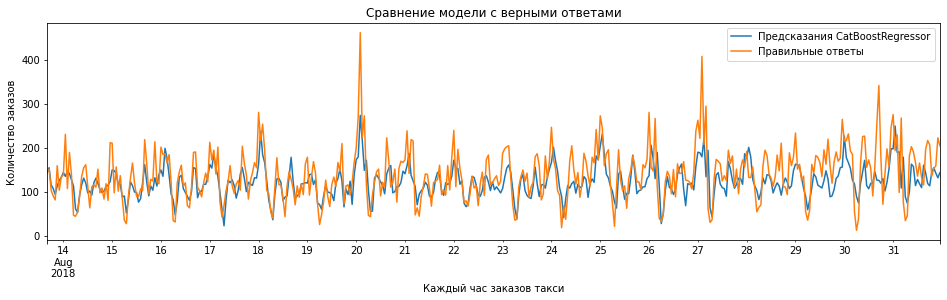

In [29]:
result = pd.DataFrame(predictions_CatBoost,index=features_test.index, columns=['Предсказания CatBoostRegressor'])
result['Правильные ответы'] = target_test
result.plot(title='Сравнение модели с верными ответами',xlabel='Каждый час заказов такси',ylabel='Количество заказов')
plt.show()

Мы видим, что предсказания нашей модели выглядят более усредненно, она попадает в тренд и сезонность, но в пиковых значениях максимального количества реальных заказов больше, чем предсказанных. 

Проверим адекватность нашего результата по сравнению со средней Dummy моделью:

In [30]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
DummyRegressor()
dummy_regr_predict = dummy_regr.predict(features_test)
mse = mean_squared_error(target_test,dummy_regr_predict)
rmse = mse**0.5
print('Среднеквадратическая ошибка для модели Дамми составляет:', rmse)

Среднеквадратическая ошибка для модели Дамми составляет: 84.69056594015109


Наш результат почти в 2 раза выше среднего Dummy так что мы можем утверждать о полезности нашей работы. 

## Вывод:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам было нужно:

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы.

1. Мы загрузили данные и выполнили их ресемплирование по одному часу.
2. Мы построили график для того чтобы визуально оценить распределние количества заказов такси. В целом мы увидели тенденцию к увеличению заказов. Для того чтобы увдиеть тренды и сезонности мы применили функцию декомпозиции. По графику трендов мы увмдели растущий тренд к увеличению числа заказов в среднем. На масштабе 5 дней мы увидели циклично повторяющуюся закономерности во временном ряду. Мы видим пиковую нагрузку в 24 часа и минимальную в 6 утра. 4-8 часов утра наблюдается минимальное количество заказов, 22-24 часа максимальная наргузка с самым большим количеством заказов в интервале. Затем мы построили график с рядом разниц. На графике увидели скользящее среднее и скользящее стандартное отклонение. Ряд выглядит стационарным визуально. Для того чтобы более точно оценить в численном виде стационарность ряда мы провели теста Дики-Фуллера. Мы получили p-value равное 2,8% , таким образом в зависимости от заданной нами мере чувстительности alpha в 1% или 5% мы можем назвать ряд как стационарным так и не стационарным. 
3. Приступили к обучению моделей. Выделили признаки. Год нам не нужен так как это одинаковый признак для всех. Построим функцию для вычисления построения остающих значений, календарных признаков, а так же скользящего среднего. Далее мы построили три модели для прогнозирования.

 - Линейнай регрессия показала RMSE 33.9
 - Случайный лес показал результат RMSE 35.3
 - CatBoostRegressor показал результат RMSE 31.1
4. Провели тестирование. Тестирование выявлило что лучшая модель CatBoostRegressor на выборке показывает RMSE 47. Наш результат почти в 2 раза выше среднего Dummy так что мы можем утверждать о полезности нашей работы. 